In [1]:

from haven import haven_jupyter as hj
from haven import haven_results as hr
from haven import haven_utils as hu

# path to where the experiments got saved
savedir_base = '/home/user/tk_knn/results/'
exp_list = None

# get experiments from the exp config
exp_config_fname = "/home/user/tk_knn/exp_configs.py"
if exp_config_fname:
    config = hu.load_py(exp_config_fname)
    exp_list = []
    for exp_group in [
        # Simple experiments to see results for. After you have run an experiment just uncomment the experiment name and then
        # run the jupyter notebook to view the results for a specific experiment.
        # "ganbert_clinc_one_percent",
        # "threshold_clinc_one_percent",
        # "flexmatch_clinc_one_percent",
        # "tk_knn_clinc_one_percent",
        
        # "tk_knn_clinc_one_percent",
        # "tk_knn_banking_one_percent",
        # "tk_knn_hwu64_one_percent",
        
        # "supervised_all_data",
        
        
                    ]:
        exp_list += config.EXP_GROUPS[exp_group]

# filter exps
filterby_list = []

# get experiments
rm = hr.ResultManager(
                      exp_list=exp_list,
                      savedir_base=savedir_base,
                      filterby_list=filterby_list,
                      verbose=0,
                      exp_groups=None,
                      job_scheduler='toolkit',
                     )

# specify display parameters

# groupby_list = ['dataset']
# title_list = ['dataset']
# legend_list = ['model']
y_metrics = ['train_loss']
x_metric = 'epoch'

# launch dashboard
hj.get_dashboard(rm, vars(), wide_display=False, enable_datatables=False)

Label(value='Loading Dashboard...', layout=Layout(width='800px'))

Output()

Output()

Output()

Output()

Output()

Output()

In [210]:
df = rm.get_score_df()

In [211]:
# This cell block and the following ones are used to parse out the best test accuracy scores from a given run.
# We use the highest validation loss and accuracy to select the best performing model from the run. We then use the test score
# associated with the highest validation scores as the test results and average results over five runs.
from collections import defaultdict
import numpy as np

experiment_to_test_accuracy = defaultdict(list)
#track the test accuracys that we need to extract to put into the paper
for exp_dict, score_list in zip(rm.exp_list, rm.get_score_lists()): 
    
    dataset = exp_dict["dataset"]
    percent_labeled = exp_dict["percent_labeled"]
    runs = exp_dict["runs"]
    model = exp_dict["model"]
    
    #for top-k and beta only
    if "top-k" in exp_dict and "beta" in exp_dict:
        top_k = exp_dict["top-k"]
        beta = exp_dict["beta"]
        exp_key = f"{top_k}_{beta}"
    elif "top-k" in exp_dict:
        top_k = exp_dict["top-k"]
        exp_key = f"{top_k}"
    
    best_val = 100.0
    test_acc = 0.0
    val_accuracy_per_cycle = np.zeros(30)
    test_accuracy_per_cycle = np.zeros(30)
    val_loss_per_cycle = np.full((30), np.inf)
    for idx, score_dict in enumerate(score_list):
        
        cycle = score_dict["cycle"]
        if "val_loss" in score_dict:
            val_loss = score_dict["val_loss"]
            if val_loss < val_loss_per_cycle[cycle]:
                val_loss_per_cycle[cycle] = val_loss

                if score_dict["val_acc"] > val_accuracy_per_cycle[cycle]:
                    val_accuracy_per_cycle[cycle] = score_dict["val_acc"]
                    test_accuracy_per_cycle[cycle] = score_dict["test_acc"]
                        
    experiment_to_test_accuracy[exp_key].append(test_accuracy_per_cycle)

    #TOP-k, Top-k knn, Top-k upper
    if "top-k" in exp_dict and "beta" in exp_dict:
        top_k = exp_dict["top-k"]
        beta = exp_dict["beta"]
        row_idx = df[(df["percent_labeled"] == percent_labeled) & (df["runs"] == runs) & (df["dataset"] == f"'{dataset}'") & (df["top-k"] == top_k) & (df["beta"] == beta)].index[0]
    elif "top-k" in exp_dict:
        top_k = exp_dict["top-k"]
        row_idx = df[(df["percent_labeled"] == percent_labeled) & (df["runs"] == runs) & (df["dataset"] == f"'{dataset}'") & (df["top-k"] == top_k)].index[0]
    else:
        #Supervised, PL, PL-T
        row_idx = df[(df["percent_labeled"] == percent_labeled) & (df["runs"] == runs) & (df["dataset"] == f"'{dataset}'") & (df["model"] == f"'{model}'")].index[0]


    test_acc = np.max(test_accuracy_per_cycle)
    df.at[row_idx, "test_acc"] = test_acc


In [212]:
clinc_df = df[df['dataset'].isin(["'clinc'"])]
banking_df = df[df['dataset'].isin(["'banking77'"])]
hwu_df = df[df['dataset'].isin(["'hwu64'"])]

#For each row in the dataframe we want to get just the percent_labeled, runs, and test_acc

clinc_df = clinc_df[["percent_labeled", "runs", "test_acc"]]
banking_df = banking_df[["percent_labeled", "runs", "test_acc"]]
hwu_df = hwu_df[["percent_labeled", "runs", "test_acc"]]




In [213]:
#At this point each dataset dataframe has a row for each experiment. 
#The test_acc column holds the max accuracy from the best cycle encountered during training
#Need to average the test_acc column across the runs for each experiment
import math

def caclualte_mean_std_confidence_interval(df):
    #For each percent_labeled value we want to get the average test_acc across the runs
    #For each percent_labeled value we want to get the 95% confidence interval for the test_acc across the runs
    df = df.groupby(["percent_labeled"]).agg({"test_acc": ["mean", "std"]})
    df.columns = ["_".join(x) for x in df.columns.ravel()]
    df["test_acc_lower"] = df["test_acc_mean"] - 1.96 * (df["test_acc_std"] / math.sqrt(5))
    df["test_acc_upper"] = df["test_acc_mean"] + 1.96 * (df["test_acc_std"] / math.sqrt(5))
    #Add a column for the confidence interval
    df["confidence_interval"] = df["test_acc_upper"] - df["test_acc_mean"]
    return df


#For each percent_labeled value we want to get the average test_acc across the runs
#For each percent_labeled value we want to get the 95% confidence interval for the test_acc across the runs
clinc_df = caclualte_mean_std_confidence_interval(clinc_df)
banking_df = caclualte_mean_std_confidence_interval(banking_df)
hwu_df = caclualte_mean_std_confidence_interval(hwu_df)

clinc_df = clinc_df * 100
banking_df = banking_df * 100
hwu_df = hwu_df * 100

clinc_df = clinc_df.round(2)
banking_df = banking_df.round(2)
hwu_df = hwu_df.round(2)

/mnt/home/miniconda/envs/ssl_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  # Remove the CWD from sys.path while we load stuff.


In [214]:
clinc_df

,test_acc_mean,test_acc_std,test_acc_lower,test_acc_upper,confidence_interval
percent_labeled,,,,,
0.01,50.28,3.42,47.28,53.27,3.00
0.02,63.99,0.97,63.14,64.84,0.85


In [215]:
banking_df

,test_acc_mean,test_acc_std,test_acc_lower,test_acc_upper,confidence_interval
percent_labeled,,,,,
0.01,49.16,3.45,46.14,52.18,3.02
0.02,59.81,1.93,58.11,61.50,1.69


In [216]:
hwu_df

,test_acc_mean,test_acc_std,test_acc_lower,test_acc_upper,confidence_interval
percent_labeled,,,,,
0.01,62.43,3.18,59.65,65.22,2.78
0.02,71.04,1.06,70.11,71.97,0.93


In [150]:
# clinc_df.index
output_str = f"{clinc_df.loc[0.01, 'test_acc_mean']} \small$\pm {clinc_df.loc[0.01, 'confidence_interval']}$ & {clinc_df.loc[0.02, 'test_acc_mean']} \small$\pm {clinc_df.loc[0.02, 'confidence_interval']}$ \\\\"
print(output_str)

53.23 \small$\pm 3.17$ & 65.37 \small$\pm 1.17$ \\


In [151]:
output_str = f"{banking_df.loc[0.01, 'test_acc_mean']} \small$\pm {banking_df.loc[0.01, 'confidence_interval']}$ & {banking_df.loc[0.02, 'test_acc_mean']} \small$\pm {banking_df.loc[0.02, 'confidence_interval']}$ \\\\"
print(output_str)

52.4 \small$\pm 3.91$ & 62.35 \small$\pm 2.18$ \\


In [152]:
output_str = f"{hwu_df.loc[0.01, 'test_acc_mean']} \small$\pm {hwu_df.loc[0.01, 'confidence_interval']}$ & {hwu_df.loc[0.02, 'test_acc_mean']} \small$\pm {hwu_df.loc[0.02, 'confidence_interval']}$ \\\\"
print(output_str)

64.41 \small$\pm 2.26$ & 72.71 \small$\pm 1.07$ \\


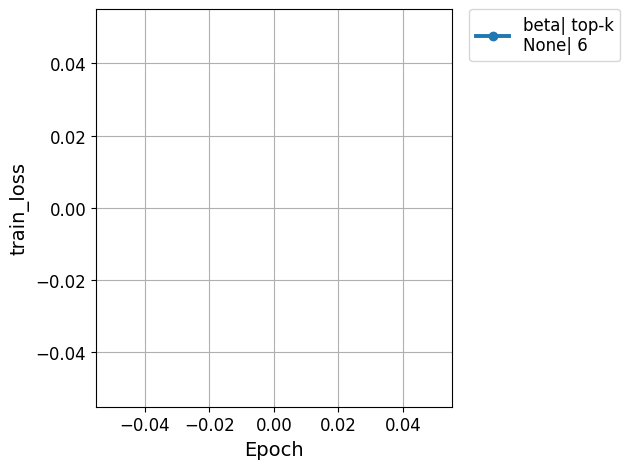

In [927]:
# get table 
rm.get_score_df().head()

# get latex 
# print(rm.get_latex_table(legend=['dataset'], metrics=['train_loss'], decimals=1, caption="Results", label='tab:results'))

# get custom plots
fig = rm.get_plot_all(
                # order='metrics_by_groups',
                avg_across='runs',
                y_metric_list=y_metrics, 
                x_metric=x_metric,
                # legend_fontsize=18,
                # x_fontsize=20,
                # y_fontsize=20,
                # xtick_fontsize=20,
                # ytick_fontsize=20,
                # title_fontsize=24,
                legend_list=['beta', 'top-k'], 
                # title_list = ['dataset'], 
                # title_format='Dataset:{}',
                # log_metric_list = ['train_loss'], 
                # groupby_list = ['dataset'],
                map_ylabel_list=[{'val_acc':'Validation Accuracy'}],
                map_xlabel_list=[{'epoch':'Epoch','cycle': 'Cycle'}],
                # figsize=(15,5),
                # plot_confidence=False,
                # savedir_plots='%s' % (name)
)

import tikzplotlib

tikzplotlib.save("test2.tex")
          

In [205]:
for exp, arys in experiment_to_test_accuracy.items():
    
    print(exp)
    # print(arys)
    summed_ary = np.zeros(30)
    for ary in arys:
        summed_ary += ary
        # print(ary)
        
    average_ary = summed_ary / 5
    
    # print(exp)
    for idx, value in enumerate(average_ary):
        print(f"{idx} {value}")
    

6_0.0
0 0.49535315985130113
1 0.583457249070632
2 0.6037174721189591
3 0.612639405204461
4 0.6278810408921933
5 0.6317843866171005
6 0.6239776951672862
7 0.6278810408921933
8 0.6302973977695168
9 0.6306691449814127
10 0.6258364312267658
11 0.6256505576208178
12 0.6278810408921933
13 0.6221189591078067
14 0.6228624535315985
15 0.616542750929368
16 0.6223048327137546
17 0.6263940520446096
18 0.6256505576208178
19 0.6241635687732341
20 0.6269516728624536
21 0.6232342007434944
22 0.6226765799256505
23 0.6234200743494424
24 0.6263940520446096
25 0.6243494423791822
26 0.6230483271375464
27 0.6254646840148699
28 0.6245353159851301
29 0.6250929368029741
6_0.25
0 0.49535315985130113
1 0.587918215613383
2 0.6033457249070633
3 0.6213754646840148
4 0.6286245353159852
5 0.6325278810408921
6 0.6425650557620818
7 0.6390334572490706
8 0.6394052044609666
9 0.6355018587360595
10 0.6388475836431227
11 0.637546468401487
12 0.6356877323420074
13 0.629368029739777
14 0.63364312267658
15 0.6369888475836432
1

pandas.core.frame.DataFrame